<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#导入数据" data-toc-modified-id="导入数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>导入数据</a></span><ul class="toc-item"><li><span><a href="#feature-mapping" data-toc-modified-id="feature-mapping-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>feature mapping</a></span></li></ul></li><li><span><a href="#模型函数" data-toc-modified-id="模型函数-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>模型函数</a></span><ul class="toc-item"><li><span><a href="#假设函数" data-toc-modified-id="假设函数-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>假设函数</a></span></li><li><span><a href="#代价函数-+-L2正则化" data-toc-modified-id="代价函数-+-L2正则化-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>代价函数 + L2正则化</a></span></li><li><span><a href="#梯度下降函数" data-toc-modified-id="梯度下降函数-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>梯度下降函数</a></span></li></ul></li><li><span><a href="#训练参数" data-toc-modified-id="训练参数-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>训练参数</a></span><ul class="toc-item"><li><span><a href="#初始化数据" data-toc-modified-id="初始化数据-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>初始化数据</a></span></li><li><span><a href="#TNC寻找最优参数" data-toc-modified-id="TNC寻找最优参数-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>TNC寻找最优参数</a></span></li><li><span><a href="#查看准确度" data-toc-modified-id="查看准确度-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>查看准确度</a></span></li></ul></li></ul></div>

**正则化**是成本函数中的一个术语，它使算法更倾向于“更简单”的模型

助于减少过拟合，提高模型的泛化能力

<img src='img/logic_multi.jpg' width=600>

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

# 导入数据

In [34]:
path = 'data/ex2data2.txt'
data = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


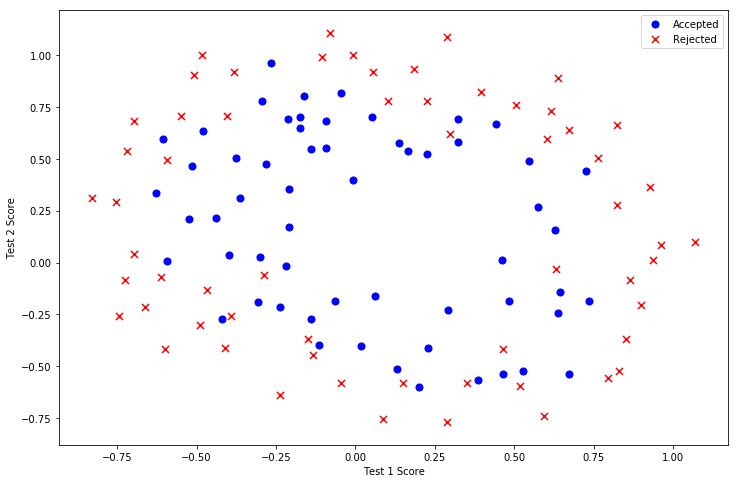

In [35]:
positive = data[data['Accepted'].isin([1])]
negative = data[data['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()

# 没有线性决策界限

## feature mapping
此次数据没有线性决策界限，构造高次多项式

In [36]:
data.insert(3, 'Ones', 1)
degree = 5
x1 = data['Test 1']
x2 = data['Test 2']

for i in range(1, degree):
    for j in range(0, i):
        data['F' + str(i-j) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data.drop('Test 1', axis=1, inplace=True)
data.drop('Test 2', axis=1, inplace=True)

data.head()

,Accepted,Ones,F10,F20,F11,F30,F21,F12,F40,F31,F22,F13
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


# 模型函数

## 假设函数

Hyper： $z = {\theta^T}X$

Sigmoid： $g\left( z \right)=\frac{1}{1+{e^{-z}}}$

组合后：

$${h_\theta }\left( x \right)=\frac{1}{1+{e^{-{\theta ^T}X}}}$$

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

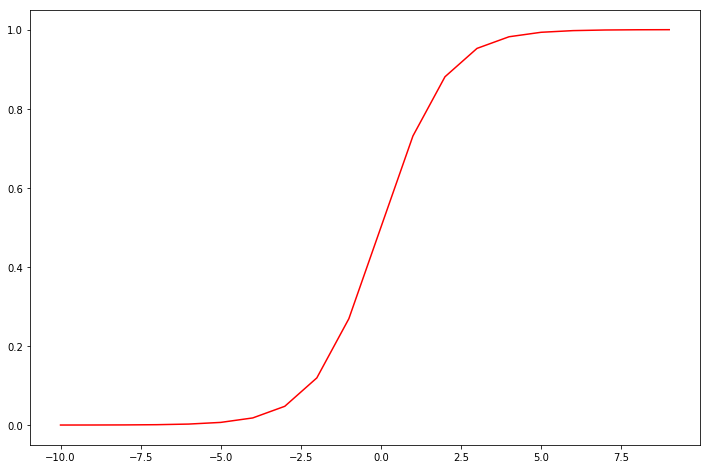

In [20]:
# 快速检查
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')
plt.show()

## 代价函数 + L2正则化

注意有一个正则化系数λ：
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{y^{(i)}}\log \left( {h_\theta }\left( {x^{(i)}} \right) \right)-\left( 1-{y^{(i)}} \right)\log \left( 1-{h_\theta }\left( {x^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^n{\theta _j^2}$$


In [54]:
def cost(theta, x, y, learningRate):
    theta = np.matrix(theta)
    x = np.matrix(x)
    y = np.matrix(y)
    
    hyper = sigmoid(np.multiply(theta, x))
    first = np.multiply(-y, np.log(hyper))
    second = np.multiply(1-y, np.log(1-hyper))
    reg = (learningRate / (2 * len(x))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(x) + reg

## 梯度下降函数
偏置项、参数项的梯度下降函数不同

\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{\theta _0}:={\theta _0}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{h_\theta }\left( {x^{(i)}} \right)-{y^{(i)}}]x_{_0}^{(i)}} \\ 
 & \text{     }{\theta _j}:={\theta _j}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({h_\theta }\left( {x^{(i)}} \right)-{y^{(i)}})x_{j}^{(i)}}\\ 
 & \text{          }\!\!\}\!\!\text{ } 
\end{align} 

In [209]:
# 返回dtheta
def gradient(theta, x, y, learningRate):
    theta = np.matrix(theta)    # 1,11
    x = np.matrix(x)            # 118,11
    y = np.matrix(y)            # 118,1
    grad = theta
    
    error = sigmoid(x*grad.T) - y           # 118,1
    dtheta = error.T * x /len(x)             # 1,11
    grad[0] = dtheta[0]
    grad[1:] = (learningRate/len(x))*grad[1:] + dtheta[1:]
    
    return grad

# 训练参数

## 初始化数据

In [214]:
cols = data.shape[1]
x = data.iloc[:,1:cols]
y = data.iloc[:,0:1]

x = np.array(x.values)
y = np.array(y.values)
theta = np.zeros(11)

learningRate = 1

In [215]:
cost(theta, x, y, learningRate)

7.624618986159398

In [216]:
gradient(theta, x, y, learningRate)

matrix([[0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
         0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
         0.00309594]])

## TNC寻找最优参数

In [217]:
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(x, y, learningRate))

## 查看准确度

In [220]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [222]:
theta_min = np.matrix(result[0])
predictions = predict(theta_min, x)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) 
           else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 80%
